In [152]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import os
from scipy import misc

%matplotlib inline
sns.set_style("darkgrid")

In [4]:
business = pd.read_json("./dataset/business.json", lines=True)

census = pd.read_csv("./dataset/census.csv")

z = pd.read_csv("./dataset/zip_to_zcta_2017.csv", error_bad_lines=False)

In [70]:
#z = z[['ZIP_CODE', 'PO_NAME', 'STATE', 'ZCTA']]

z.columns = ['zip', 'po', 'state', 'zcta']

census.columns = ['zcta', 'population']

In [44]:
business.postal_code = pd.to_numeric(business.postal_code, errors='coerce')

In [16]:
business.head(1)

,address,attributes,business_id,categories,city,hours,is_open,latitude,longitude,name,neighborhood,postal_code,review_count,stars,state
0,691 Richmond Rd,"{u'RestaurantsPriceRange2': 2, u'BusinessParki...",YDf95gJZaq05wvo7hTQbbQ,"[Shopping, Shopping Centers]",Richmond Heights,"{u'Monday': u'10:00-21:00', u'Tuesday': u'10:0...",1,41.541716,-81.493116,Richmond Town Square,,44143,17,2.0,OH


In [23]:
z.head(1)

,ZIP_CODE,PO_NAME,STATE,ZCTA
0,501,Holtsville,NY,11742


In [71]:
census_merge = census.merge(z, how = 'right', on = 'zcta')

In [72]:
census_merge.head()

,zcta,population,zip,po,state
0,1001,16769.0,1001,Agawam,MA
1,1002,29049.0,1002,Amherst,MA
2,1002,29049.0,1004,Amherst,MA
3,1002,29049.0,1059,North Amherst,MA
4,1003,10372.0,1003,Amherst,MA


In [28]:
len(census_merge), len(z), len(census)

(41297, 41184, 33092)

In [73]:
business_merge = business.merge(census_merge, left_on='postal_code', right_on='zip')

In [74]:
len(business_merge), len(census_merge), len(business)

(116769, 41297, 156639)

In [126]:
def is_restaurant(x):
    if 'Restaurants' in x['categories']: 
        return True
    return False

In [75]:
b = business_merge[business_merge.state_x == business_merge.state_y]
b = b[['attributes', 'categories', 'city', 'zip', 'zcta', 'review_count', 'stars','population', 'po', 'state_x']]

b.stars = pd.to_numeric(b.stars)
b.population = pd.to_numeric(b.population)

In [127]:
b['is_restaurant'] = b.apply(is_restaurant, axis=1)

In [128]:
b.head()

,attributes,categories,city,zip,zcta,review_count,stars,population,po,state_x,population_bin,is_restaurant
0,"{u'RestaurantsPriceRange2': 2, u'BusinessParki...","[Shopping, Shopping Centers]",Richmond Heights,44143,44143,17,2.0,24499.0,Cleveland,OH,2,False
1,"{u'RestaurantsReservations': False, u'Business...","[Restaurants, Pizza]",Cleveland,44143,44143,6,3.5,24499.0,Cleveland,OH,2,True
2,"{u'BusinessParking': {u'garage': False, u'stre...","[Candy Stores, Specialty Food, Food]",Richmond Heights,44143,44143,11,4.0,24499.0,Cleveland,OH,2,False
3,"{u'BusinessAcceptsCreditCards': True, u'Restau...","[Women's Clothing, Department Stores, Shopping...",Highland Heights,44143,44143,11,2.5,24499.0,Cleveland,OH,2,False
4,"{u'GoodForMeal': {u'dessert': False, u'latenig...","[Restaurants, American (Traditional), Bars, Ni...",Cleveland,44143,44143,4,4.0,24499.0,Cleveland,OH,2,True


In [129]:
b = b[b.is_restaurant == True]

### Do places w/more people have higher stars? Try to regress population and stars

#### LR

In [130]:
regr = LinearRegression()
regr.fit(b.population.values.reshape(-1, 1), b.stars.values)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [131]:
sample = b.sample(500)

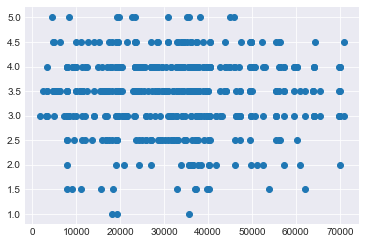

In [132]:
plt.scatter(sample.population, sample.stars)

In [133]:
regr.coef_, regr.intercept_

(array([ -2.17576171e-06]), 3.4985827776800664)

In [134]:
regr.score(b.population.values.reshape(-1, 1), b.stars.values)

0.0019140143740579152

#### PR

In [95]:
def polyfit(x, y, degree):
    results = {}

    coeffs = np.polyfit(x, y, degree)

     # Polynomial Coefficients
    results['polynomial'] = coeffs.tolist()

    # r-squared
    p = np.poly1d(coeffs)
    # fit values, and mean
    yhat = p(x)                         # or [p(z) for z in x]
    ybar = np.mean(y)          # or sum(y)/len(y)
    ssreg = np.sum((yhat-ybar)**2)   # or sum([ (yihat - ybar)**2 for yihat in yhat])
    sstot = np.sum((y - ybar)**2)    # or sum([ (yi - ybar)**2 for yi in y])
    results['determination'] = ssreg / sstot

    return results

In [135]:
print polyfit(b.population, b.stars, 2)

{'polynomial': [3.773120146387076e-11, -4.739045772096609e-06, 3.532372238338288], 'determination': 0.0021159960191661355}


(array([  7.38000000e+03,   8.90000000e+03,   1.85940000e+04,
          1.64590000e+04,   3.04760000e+04,   1.71620000e+04,
          8.11600000e+03,   6.18500000e+03,   1.80800000e+03,
          1.00000000e+00]),
 array([     0. ,   8464.1,  16928.2,  25392.3,  33856.4,  42320.5,
         50784.6,  59248.7,  67712.8,  76176.9,  84641. ]),
 <a list of 10 Patch objects>)

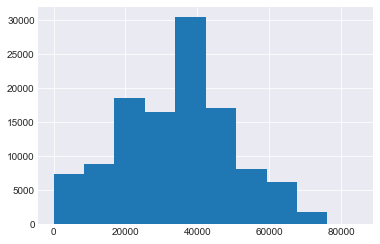

In [117]:
plt.hist(b.population)

In [136]:
b["population_bin"] = pd.cut(b.population, bins=10, labels=False)

In [137]:
b.head()

,attributes,categories,city,zip,zcta,review_count,stars,population,po,state_x,population_bin,is_restaurant
1,"{u'RestaurantsReservations': False, u'Business...","[Restaurants, Pizza]",Cleveland,44143,44143,6,3.5,24499.0,Cleveland,OH,3,True
4,"{u'GoodForMeal': {u'dessert': False, u'latenig...","[Restaurants, American (Traditional), Bars, Ni...",Cleveland,44143,44143,4,4.0,24499.0,Cleveland,OH,3,True
5,"{u'GoodForMeal': {u'dessert': False, u'latenig...","[Restaurants, Event Planning & Services, Pizza...",Cleveland,44143,44143,8,3.5,24499.0,Cleveland,OH,3,True
8,"{u'GoodForMeal': {u'dessert': False, u'latenig...","[Restaurants, Pizza]",Highland Heights,44143,44143,9,4.0,24499.0,Cleveland,OH,3,True
12,"{u'GoodForMeal': {u'dessert': False, u'latenig...","[Caterers, Restaurants, Event Planning & Servi...",Highland Heights,44143,44143,12,3.0,24499.0,Cleveland,OH,3,True


(array([  3.05600000e+04,   2.81000000e+02,   3.90000000e+01,
          1.40000000e+01,   6.00000000e+00,   5.00000000e+00,
          2.00000000e+00,   1.00000000e+00,   1.00000000e+00,
          2.00000000e+00]),
 array([  3.00000000e+00,   7.00600000e+02,   1.39820000e+03,
          2.09580000e+03,   2.79340000e+03,   3.49100000e+03,
          4.18860000e+03,   4.88620000e+03,   5.58380000e+03,
          6.28140000e+03,   6.97900000e+03]),
 <a list of 10 Patch objects>)

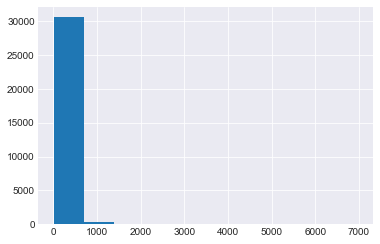

In [138]:
plt.hist(b.review_count)

In [139]:
d = {'stars': ['mean', 'std', 'count']}
avg_star_per_pop_bin = b[['stars', 'population_bin']].groupby('population_bin').agg(d)

In [163]:
avg_star_per_pop_bin

level_0 index population_bin     stars                        se
                                    mean       std count          
0       0     0              0  3.541244  0.776857  1479  0.020200
1       1     1              1  3.476236  0.752710  3114  0.013489
2       2     2              2  3.475346  0.783288  3468  0.013301
3       3     3              3  3.444246  0.783902  4197  0.012100
4       4     4              4  3.391999  0.809432  4162  0.012547
5       5     5              5  3.394353  0.810135  6233  0.010261
6       6     6              6  3.390925  0.812882  3328  0.014091
7       7     7              7  3.429084  0.818800  2369  0.016823
8       8     8              8  3.389470  0.763625  1624  0.018949
9       9     9              9  3.385806  0.862181   937  0.028166

In [162]:
avg_star_per_pop_bin = avg_star_per_pop_bin.reset_index()
avg_star_per_pop_bin['se'] = avg_star_per_pop_bin['stars']['std'] * 1.0 / np.sqrt(avg_star_per_pop_bin['stars']['count'])

Text(0.5,1,u'Average Stars per Population Bin')

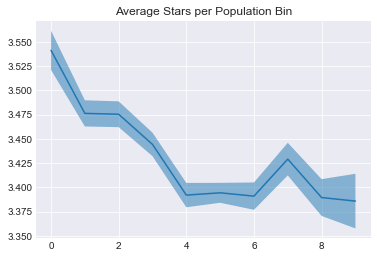

In [170]:
plt.plot(avg_star_per_pop_bin['stars']['mean'])
x = avg_star_per_pop_bin['population_bin']
y = avg_star_per_pop_bin['stars']['mean']
error = avg_star_per_pop_bin['se']
plt.fill_between(x, y-error, y+error, alpha=0.5)

plt.title("Average Stars per Population Bin")

### Reviewer demographics

In [156]:
review = pd.read_json("./dataset/review.json", lines=True)

In [158]:
user.columns

Index([u'average_stars', u'compliment_cool', u'compliment_cute',
       u'compliment_funny', u'compliment_hot', u'compliment_list',
       u'compliment_more', u'compliment_note', u'compliment_photos',
       u'compliment_plain', u'compliment_profile', u'compliment_writer',
       u'cool', u'elite', u'fans', u'friends', u'funny', u'name',
       u'review_count', u'useful', u'user_id', u'yelping_since'],
      dtype='object')

In [167]:
user = user[['average_stars', 'review_count', 'fans', 'yelping_since']]

In [178]:
business.attributes[0]

{u'BikeParking': True,
 u'BusinessParking': {u'garage': False,
  u'lot': True,
  u'street': False,
  u'valet': False,
  u'validated': False},
 u'RestaurantsPriceRange2': 2,
 u'WheelchairAccessible': True}

### random

In [149]:
def resize(img, p):
    return misc.imresize(img, p)

In [154]:
for f in os.listdir("./photos/"):
    img = misc.imread("./photos/" + f)
    img = resize(img, 0.5) #TODO replace p
    misc.imsave('./photos2/' + f, img)